In [29]:
import os
import sys
import random
import logging
from datetime import datetime
import gc
from tqdm import tqdm

import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader

In [20]:
import sys
sys.path.append("../training")
from utils.dataset import CustomDataset
from preprocessing.preprocess import img_transformer
from model.architectures.densenet import DenseNet_121
from utils.score import cal_scores

In [21]:
ARGS = {
    "SEED": 42,
    "DEVICE": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "DATA_DIR": "../data/raw",
    "MODEL_DIR": "../model",
    "LOG_DIR": "../log/test",
    "UNDER_SAMPLING": False,
    "IMAGE_SIZE": (29, 29),
    "BATCH_SIZE": 512,
    "NUM_CLASSES": 49,
    "MODEL_NAME": "densenet",
    "CRITERION": "CrossEntropyLoss",
    "OPTIMIZER": "AdamW",
    "LR": 1e-05,
    "T_MAX": 500,
    "MIN_LR": 1e-06,
    "EPOCH": 40,
}

In [22]:
transformer = img_transformer(image_size=ARGS["IMAGE_SIZE"])

# Create Dataset
test_dataset = CustomDataset(
    images_npz=os.path.join(ARGS["DATA_DIR"], "k49-test-imgs.npz"),
    labels_npz=os.path.join(ARGS["DATA_DIR"], "k49-test-labels.npz"),
    transformer=transformer,
    exec_under_sampling=ARGS["UNDER_SAMPLING"],
    num_classes=ARGS["NUM_CLASSES"],
)

test_loader = DataLoader(
    test_dataset, batch_size=ARGS["BATCH_SIZE"], shuffle=True
)

# Model
device = ARGS["DEVICE"]
model = DenseNet_121(num_classes=ARGS["NUM_CLASSES"])
model.load_state_dict(
    torch.load(os.path.join(ARGS["MODEL_DIR"], "densenet.pth"))
)
model.to(device)

DenseNet_121(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [23]:
def predict(
    model,
    test_loader: DataLoader,
    device: str,
):

    model.eval()
    true_labels = []
    pred_probs = []

    for batch in tqdm(test_loader, desc="Test", leave=False):

        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        true_labels.append(labels.detach().cpu().numpy())
        pred_probs.append(outputs.detach().cpu().numpy())

    scores = cal_scores(true_labels, pred_probs)

    gc.collect()
    return scores, true_labels, pred_probs

In [34]:
# Test
test_scores, true_labels, pred_probs = predict(model, test_loader, device)
test_accuracy = test_scores["accuracy"]
test_precision = test_scores["precision"]
test_recall = test_scores["recall"]
test_f1_score = test_scores["f1_score"]

print(
    f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}  F1_Score: {test_f1_score:.4f}"
)

Accuracy: 0.9237, Precision: 0.9134, Recall: 0.9125  F1_Score: 0.9123


In [35]:
pred_labels = np.argmax(np.concatenate(pred_probs), axis=1)
true_labels = np.concatenate(true_labels)

In [38]:
report = classification_report(true_labels, pred_labels)

In [39]:
print(report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1000
           1       0.97      0.97      0.97      1000
           2       0.93      0.96      0.95      1000
           3       0.84      0.90      0.87       126
           4       0.93      0.95      0.94      1000
           5       0.91      0.89      0.90      1000
           6       0.93      0.89      0.91      1000
           7       0.93      0.90      0.92      1000
           8       0.85      0.93      0.89       767
           9       0.93      0.92      0.93      1000
          10       0.97      0.92      0.95      1000
          11       0.93      0.93      0.93      1000
          12       0.91      0.90      0.90      1000
          13       0.92      0.81      0.86       678
          14       0.93      0.87      0.90       629
          15       0.92      0.95      0.93      1000
          16       0.93      0.96      0.94       418
          17       0.92    

44, 45が比較的f1-scoreが小さい

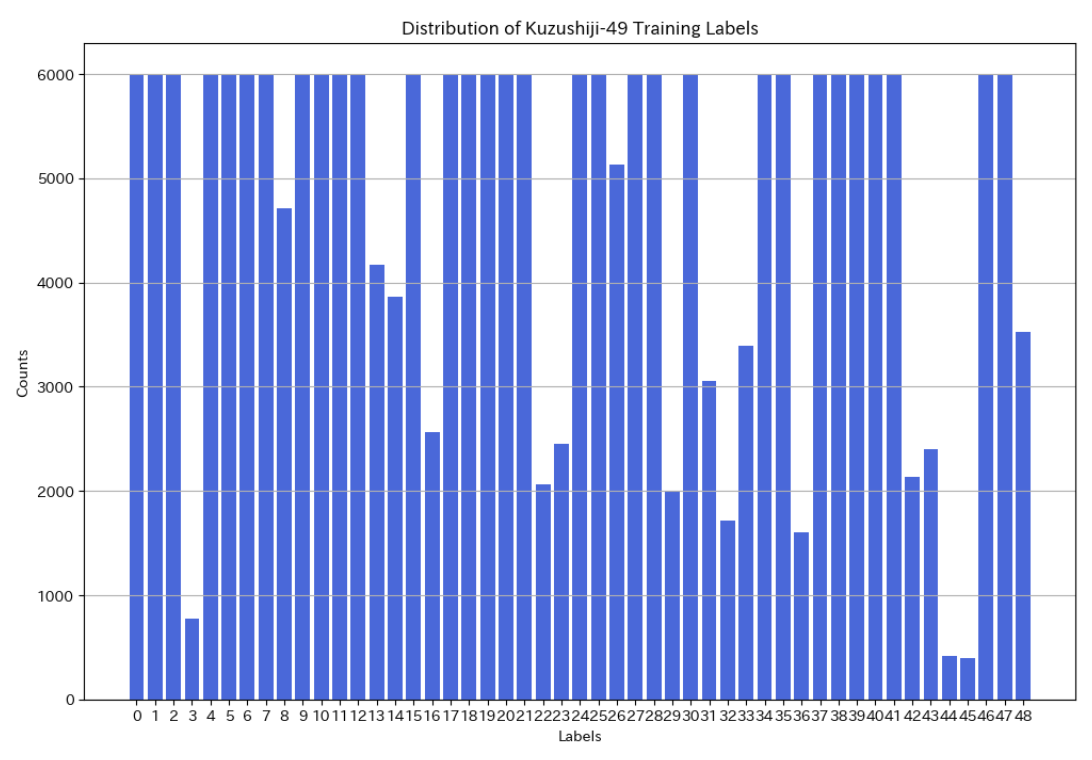

以前分析したラベルごとのデータ数を見ると44, 45はデータ数が少ないため、うまく学習できていないことが考えられる。